# Using linear revolution invariance (LRI) - the simple version

This is a notebook which will show you how to generate and deblur the output of a linear revolution-invariant (i.e., rotationally-symmetric) imaging system. These methods were devoloped in [Linear Revolution-Invariance: Modeling and Deblurring Shift-Varying Imaging Systems](https://arxiv.org/abs/2206.08928).

In particular, there are only really 2 main functions of use: blur and deblur; they do exactly as their names suggest. Both require a radial stack of PSFs from the system to compute which can be gotten from the calibrate function, which takes in a single calibration image. That is, LRI blurring and deblurring requires only a calibration single image from the system of interest---one that contains a few randomly scattered PSFs.

The process goes as follows: 
1. Obtain a calibration image of a few point sources from your imaging system (or directly get its Seidel coefficients)

2. Plug in the calibration image into ```calibrate``` which returns a radial stack of rotationally fourier transforms of PSFs

3. Pass in the PSF stack and your image of interest to either ```blur``` or ```deblur``` and get back the corresponding result.


## Setup, blurring, and deblurring

For the simple version we will demonstrate the barebones utility of setup, blur, and deblur

In [1]:
from functions import * # here we import our 3 main functions: calibrate, blur, and deblur

# here are some basics we will need
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from PIL import Image

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
print('Using ' +str(device) + ' for computation')

Using cuda:0 for computation


computing radial stack of PSFs...


100%|██████████| 512/512 [00:14<00:00, 34.67it/s]


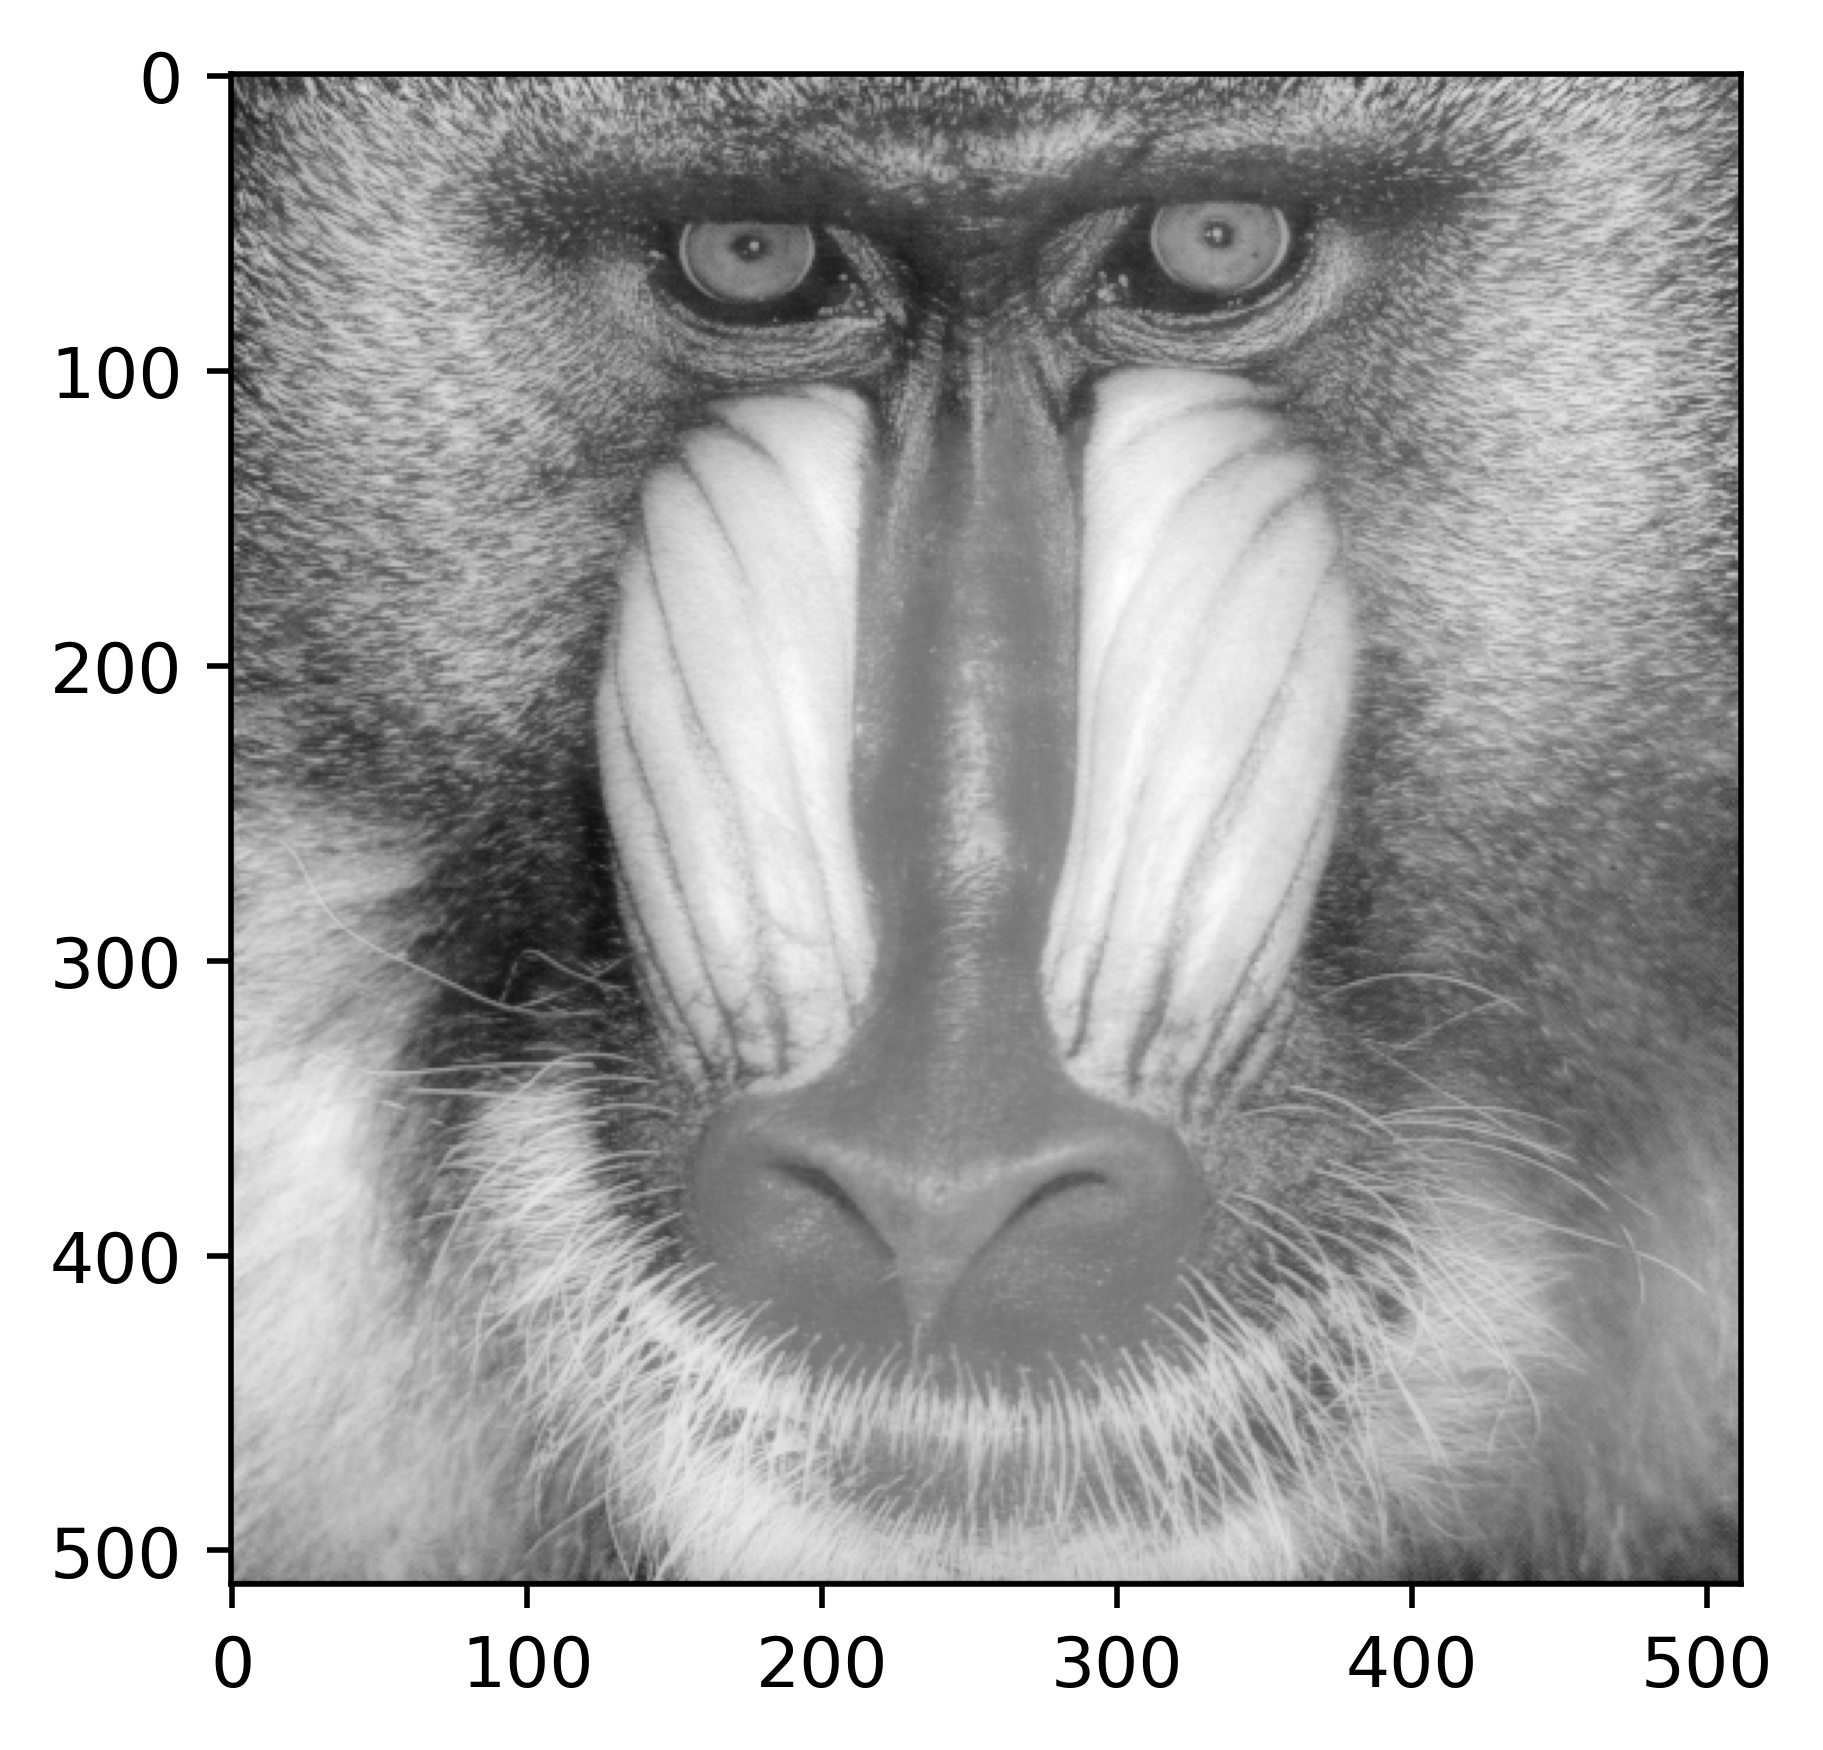

In [2]:
# assume we already had access to Seidel coefficients
seidel_coeffs = [0, 5, 3, 3, 0, 0]

# this dim specifies the size of the images we are dealing with, they ought to be square (i.e., dim x dim)
dim=512

# we can choose to tradeoff speed and accuracy using num_psfs, which determines how many PSFs we sample.
num_psfs = 512 # here we will choose half the fully accurate PSFs (dim) because it doubles the speed and is still effective

# this is a test image
baboon = resize(io.imread('test_images/baboon.png'), [dim, dim])

# here we get our PSF stack (in practice we recommend cacheing this). For now restricted to only the first 3 seidel coeffs
psf_stack_roft, seidel_coeffs = calibrate(None, seidel_coeffs=seidel_coeffs, desired_dim=dim, num_psfs=num_psfs, device=device)

# now we run the LRI forward model on the test image using the psf stack
blurry_baboon = blur(baboon, psf_stack_roft, device=device)

# let's see the blurred image
util.show(blurry_baboon.detach().cpu())

/home/amit/projects/lri/_src/opt.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  estimate = torch.tensor(measurement, device=device).float()
/home/amit/projects/lri/_src/opt.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  measurement = torch.tensor(measurement, device=device).float()
100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


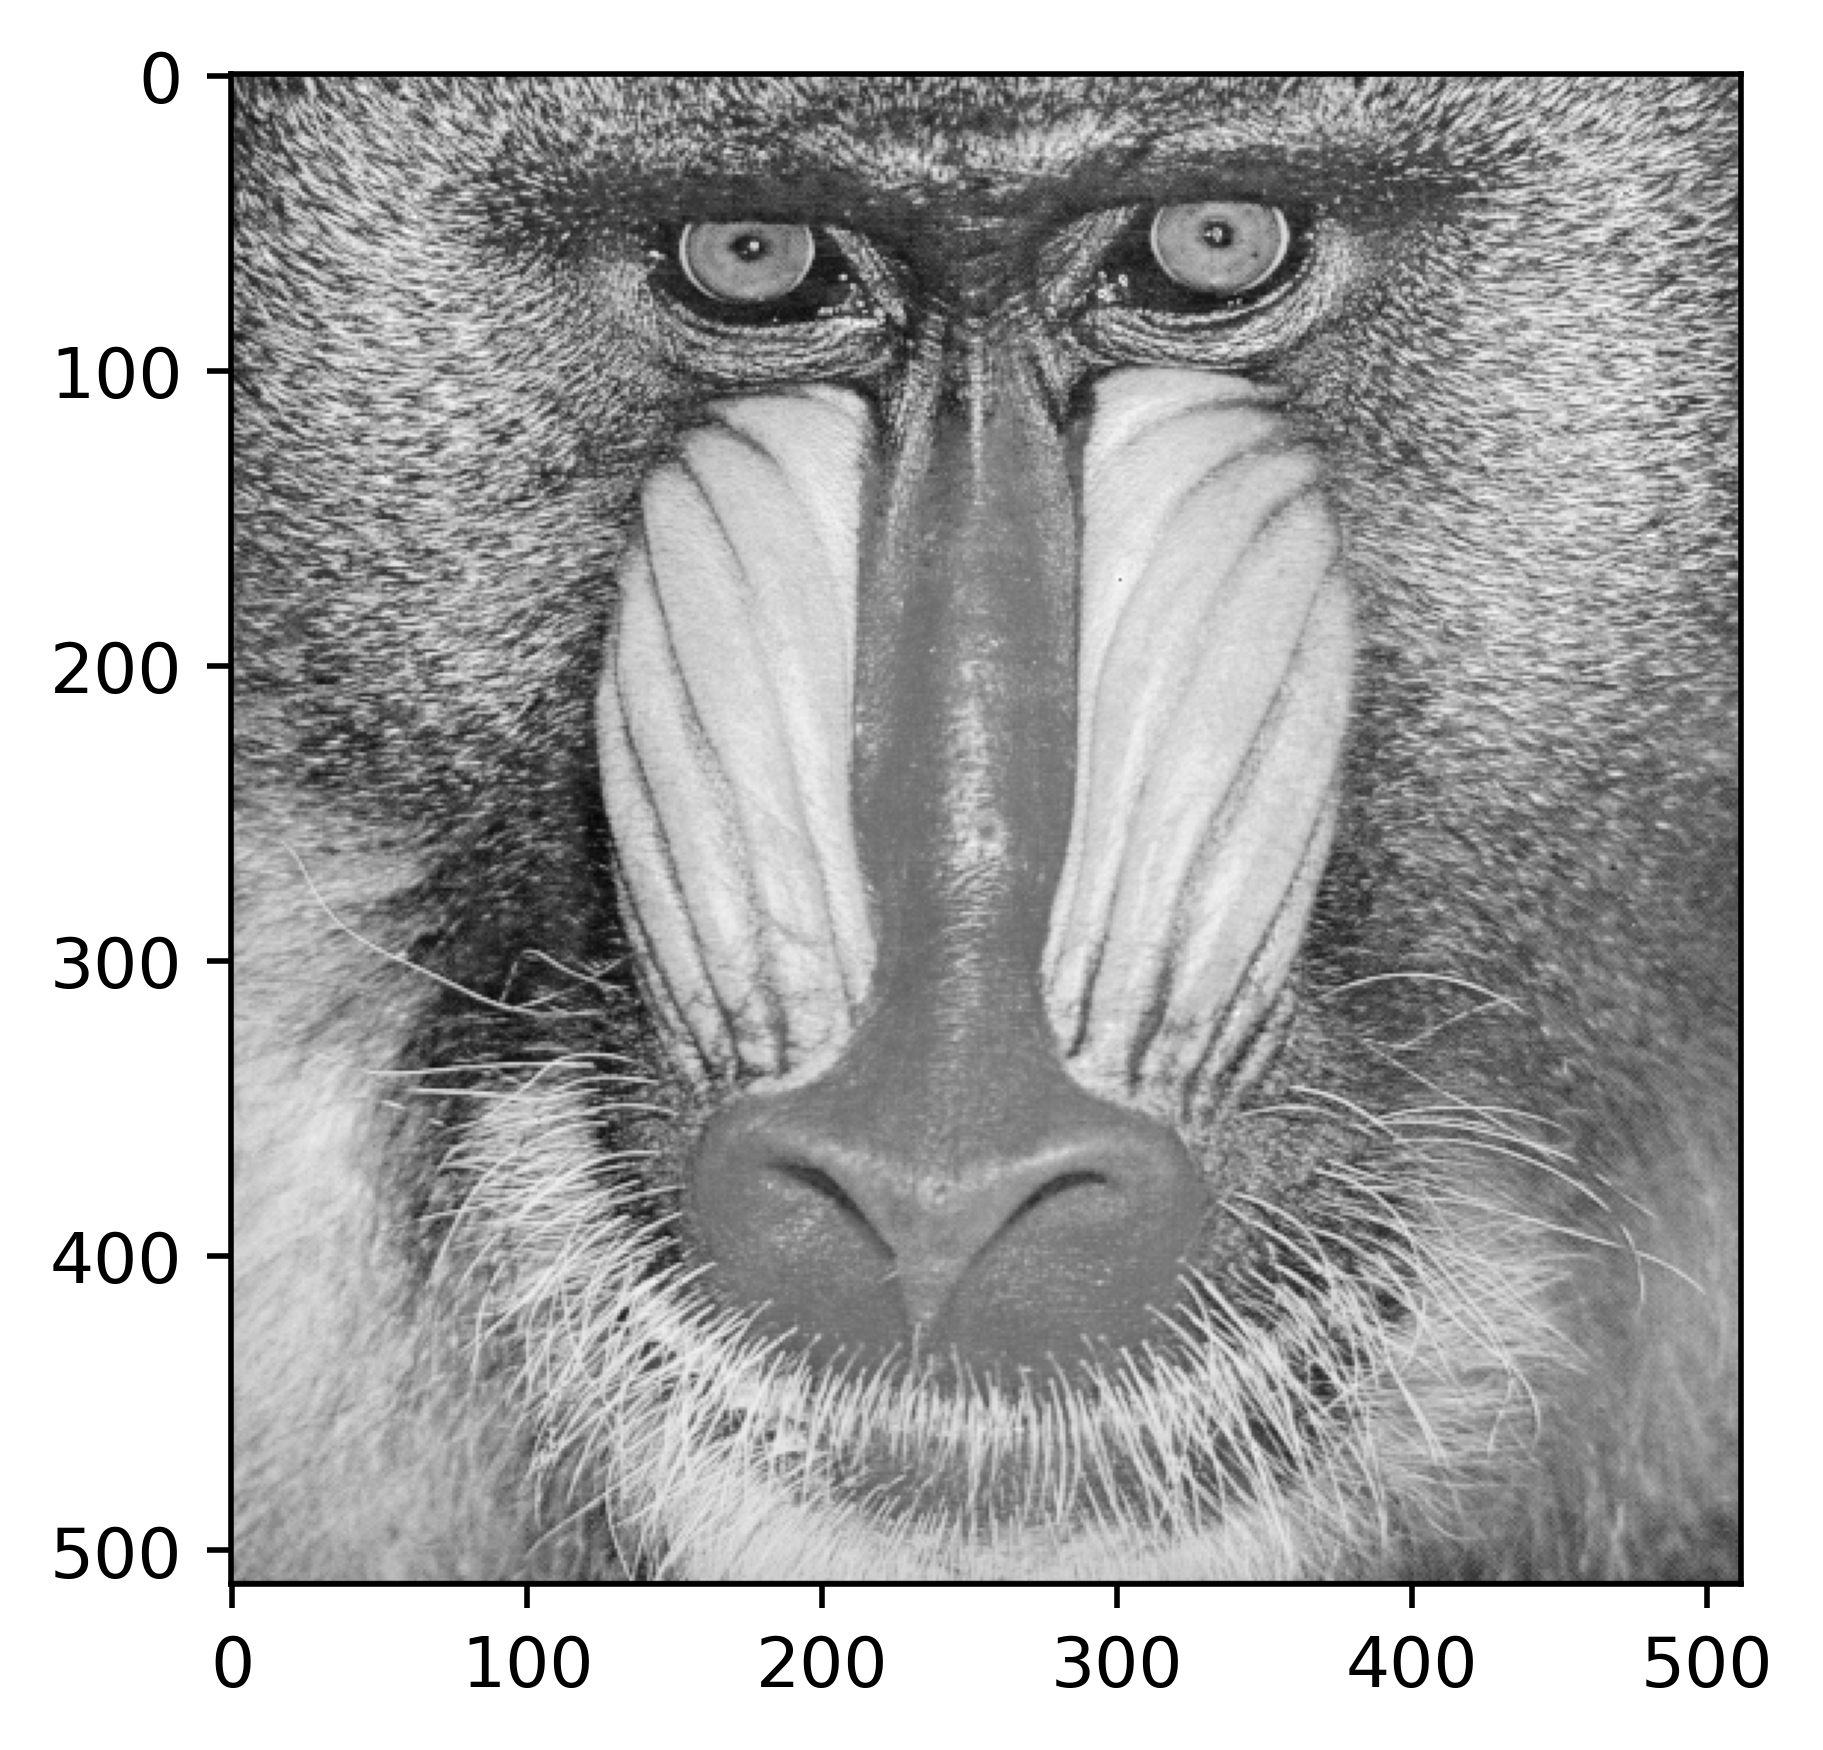

In [3]:
# finally we apply the deblurring
blurry_baboon = util.normalize(blurry_baboon)
deblurred_baboon = deblur(blurry_baboon, psf_stack_roft, device=device)
util.show(deblurred_baboon)